# EqualFrequencyDiscretiser + WoEEncoder

This is very useful for linear models, because by using discretisation + a monotonic encoding we create monotonic variables, from those that before were not originally. And this tends to hep improve the performance of the model. 

## EqualFrequencyDiscretiser

The EqualFrequencyDiscretiser() divides continuous numerical variables
into contiguous equal frequency intervals, that is, intervals that contain
approximately the same proportion of observations.

The interval limits are determined by the quantiles. The number of intervals,
i.e., the number of quantiles in which the variable should be divided is
determined by the user.

<b>Note</b>: Read EqualFrequencyDiscretiser notebook to know more about this transformer

## WoEEncoder

This encoder replaces the labels by the weight of evidence 
#### It only works for binary classification.

The weight of evidence is given by: log( p(1) / p(0) )

<b>Note:</b> Read WoEEncoder notebook to know more about this transformer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import WoEEncoder
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = [15,5]

In [19]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float')
    data['fare'] = data['fare'].astype('float')
    data['embarked'].fillna('C', inplace=True)
    data.drop(labels=['boat', 'body', 'home.dest'], axis=1, inplace=True)
    return data

In [21]:
data = load_titanic()
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S


In [22]:
# let's separate into training and testing set
X = data.drop(['survived', 'name', 'ticket'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train :" ,X_train.shape)
print("X_test :" ,X_test.shape)

X_train : (916, 8)
X_test : (393, 8)


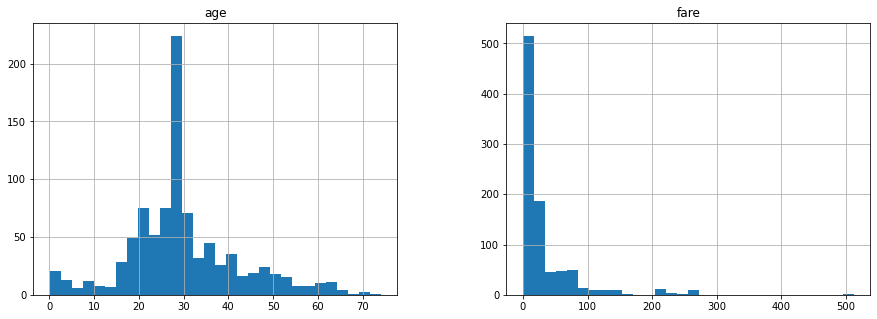

In [17]:
# we will use two continuous variables for transformation
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [36]:
# pipeline 

transformer = Pipeline(steps=[('EqualFrequencyDiscretiser', EqualFrequencyDiscretiser(q=4,
                                                                                      variables=['age','fare'],
                                                                                      return_object=True)),#returns values as categorical
                              ('WoEEncoder',WoEEncoder(variables=['age','fare']))
                             ])
transformer.fit(X_train,y_train)

Pipeline(steps=[('EqualFrequencyDiscretiser',
                 EqualFrequencyDiscretiser(q=4, return_object=True,
                                           variables=['age', 'fare'])),
                ('WoEEncoder', WoEEncoder(variables=['age', 'fare']))])

In [37]:
transformer.named_steps['EqualFrequencyDiscretiser'].binner_dict_

{'age': [-inf, 23.0, 28.0, 35.0, inf],
 'fare': [-inf, 7.8958, 14.4542, 31.275, inf]}

In [38]:
transformer.named_steps['WoEEncoder'].encoder_dict_

{'age': {0: 0.07533270507296917,
  1: -0.260402163917158,
  2: 0.3237107275657203,
  3: 0.05769015189511875},
 'fare': {0: -0.5990108946387251,
  1: -0.41504696424627724,
  2: 0.142571903020815,
  3: 0.7852653023249282}}

In [41]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1139,3,male,0.057690,0,0,-0.599011,n,S
533,2,female,0.075333,0,1,0.142572,n,S
459,2,male,0.057690,1,0,0.142572,n,S
1150,3,male,-0.260402,0,0,0.142572,n,S
393,2,male,-0.260402,0,0,0.785265,n,S


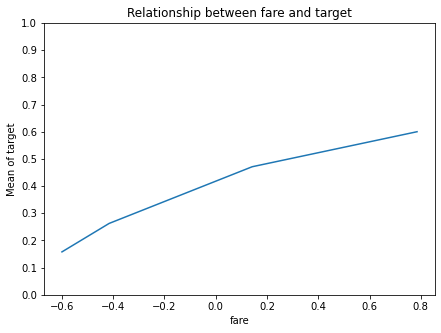

In [44]:
# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("fare")["survived"].mean().plot()
#plt.xticks([0,1,2])
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()